## Data Analysis
In this notebook, I am loading the extracted wildifire data to conduct the analysis. This notebook contains the steps involved to estimate smoke levels resulting from wildfires in Rialto, California.

This notebook serves as a comprehensive guide for the data preprocessing phase, where we transform raw data into the essential information required for the development of smoke estimators. The primary objective is to create an annual estimate of wildfire smoke in Rialto, California. To accomplish this, we will meticulously filter and refine the data based on specific criteria, ensuring its relevance to our analysis.


In [42]:
# additional import statements.
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:

with open("fire_distance_info.json") as file:
    data = json.load(file)

filtered_records = []

for record_name, record_data in data.items():
    # Extract year and shortest distance
    year = record_data.get("year")
    shortest_distance = record_data.get("distance_shortest", [None])[0]

    # Apply filters for year and shortest distance
    if year and year >= 1964 and shortest_distance and shortest_distance < 650:
        filtered_records.append({
            "name": record_name,
            "year": year,
            "shortest_distance": shortest_distance,
            "size": record_data.get("size"),
            "type": record_data.get("type"),
            "avg_distance": record_data.get("avg_distance"),
            "perimeter_start": record_data.get("perimeter_start")
        })

with open("filtered_records.json", "w") as outfile:
    json.dump(filtered_records, outfile, indent=4)

print("Filtered records have been saved to 'filtered_records.json'")


Filtered records have been saved to 'filtered_records.json'


Here, I am converting the json to dataframe

In [ ]:
import pandas as pd
import json

# Load the filtered JSON data from the file
with open("filtered_records.json") as file:
    filtered_data = json.load(file)

# Convert the JSON data to a pandas DataFrame
df = pd.DataFrame(filtered_data)

# Print the number of records in the DataFrame
print("Number of records:", len(df))

# Display the first few rows of the DataFrame (optional)
print(df.head())

#save this df to csv
df.to_csv("fire_distance_info.csv", index=False)


Number of records: 41753
                             name  year  shortest_distance          size  \
0           1964-14599-COYOTE (4)  1964         123.279085  65338.877636   
1         1964-14600-C. HANLY (5)  1964         419.720237  55960.694158   
2        1964-14601-COZY DELL (5)  1964          11.207826  19218.105903   
3  1964-14602-HAYFORK HWY. #2 (5)  1964         540.154692  18712.494746   
4          1964-14603-MATTOLE (5)  1964         565.178092  16887.001024   

       type  avg_distance                            perimeter_start  
0  Wildfire    133.408494   [34.60265585007984, -119.54285640036905]  
1  Wildfire    426.394440  [38.660638120859986, -122.65897826761605]  
2  Wildfire     14.744380   [34.32833720156216, -117.52033033175124]  
3  Wildfire    543.265644  [40.635026047345605, -122.96024967708313]  
4  Wildfire    568.269581    [40.2976463300949, -124.23582184752149]  


In the next steps, I will be using Air Quality Index data to use along with the wildfire data to continue the analysis. The data acquisition for the AQI index is carried out in a separate script.

In [47]:
# read the csv fire_distance_info
wildfire_df = pd.read_csv("fire_distance_info.csv")

In [ ]:
wildfire_df.head()

,name,year,shortest_distance,size,type,avg_distance,perimeter_start
0,1964-14599-COYOTE (4),1964,123.279085,65338.877636,Wildfire,133.408494,"[34.60265585007984, -119.54285640036905]"
1,1964-14600-C. HANLY (5),1964,419.720237,55960.694158,Wildfire,426.394440,"[38.660638120859986, -122.65897826761605]"
2,1964-14601-COZY DELL (5),1964,11.207826,19218.105903,Wildfire,14.744380,"[34.32833720156216, -117.52033033175124]"
3,1964-14602-HAYFORK HWY. #2 (5),1964,540.154692,18712.494746,Wildfire,543.265644,"[40.635026047345605, -122.96024967708313]"
4,1964-14603-MATTOLE (5),1964,565.178092,16887.001024,Wildfire,568.269581,"[40.2976463300949, -124.23582184752149]"


In [4]:
# calculate number of records for each year
wildfire_df['year'].value_counts()

,count
year,
2020,2081
2017,1687
2006,1485
2018,1412
2019,1384
2012,1325
2011,1258
2007,1241
2005,1210


In [48]:
fire_counts = wildfire_df['year'].value_counts().reset_index()
fire_counts.columns = ['year', 'count']

# Calculate the total number of fires
total_fires = fire_counts['count'].sum()

# Calculate weights for each year
fire_counts['weight'] = fire_counts['count'] / total_fires

# Display the result
print(fire_counts)

# merge fire_counts with wildfire dataframe
wildfire_df = pd.merge(wildfire_df, fire_counts, on='year', how='left')

    year  count    weight
0   2020   2081  0.049841
1   2017   1687  0.040404
2   2006   1485  0.035566
3   2018   1412  0.033818
4   2019   1384  0.033147
5   2012   1325  0.031734
6   2011   1258  0.030130
7   2007   1241  0.029722
8   2005   1210  0.028980
9   2008   1166  0.027926
10  2016   1153  0.027615
11  2013   1063  0.025459
12  2009   1020  0.024429
13  2015    961  0.023016
14  2001    948  0.022705
15  2010    936  0.022418
16  2003    928  0.022226
17  1999    919  0.022010
18  1996    897  0.021483
19  2000    893  0.021388
20  2004    859  0.020573
21  2014    859  0.020573
22  2002    817  0.019567
23  1987    746  0.017867
24  1985    745  0.017843
25  1994    696  0.016669
26  1988    665  0.015927
27  1995    628  0.015041
28  1989    623  0.014921
29  1984    589  0.014107
30  1998    578  0.013843
31  1981    574  0.013748
32  1986    569  0.013628
33  1980    563  0.013484
34  1997    542  0.012981
35  1992    538  0.012885
36  1979    533  0.012766
37  1990    

In [49]:
# agg and show the number of rows for the column type
wildfire_df.groupby("type").size()


,0
type,
Likely Wildfire,1981
Prescribed Fire,7014
Unknown - Likely Prescribed Fire,194
Unknown - Likely Wildfire,63
Wildfire,32501


In [50]:
size_min = wildfire_df['size'].min()
size_max = wildfire_df['size'].max()
value_range = size_max - size_min

value_range

1032651.4212888828

In [51]:
total_range = 1032651.4212888828  # Your calculated range
num_buckets = 10  # Define the number of buckets you want

# Calculate bucket size
bucket_size = total_range / num_buckets

# Generate buckets
buckets = [(i * bucket_size, (i + 1) * bucket_size) for i in range(num_buckets)]

# Display the buckets
buckets

[(0.0, 103265.14212888828),
 (103265.14212888828, 206530.28425777657),
 (206530.28425777657, 309795.42638666485),
 (309795.42638666485, 413060.56851555314),
 (413060.56851555314, 516325.7106444414),
 (516325.7106444414, 619590.8527733297),
 (619590.8527733297, 722855.994902218),
 (722855.994902218, 826121.1370311063),
 (826121.1370311063, 929386.2791599946),
 (929386.2791599946, 1032651.4212888828)]

In [52]:

def assign_size_weight(value):
    for i, (lower, upper) in enumerate(buckets, start=1):  # start weight index from 1
        if lower <= value < upper:
            return i
    return len(buckets)  # Assign the last bucket if it meets the upper range

# Apply to the 'size' column and create a new column 'size_weight'
wildfire_df['size_weight'] = wildfire_df['size'].apply(assign_size_weight)

In [53]:
fire_type_weights = {
    "Wildfire": 1.0,
    "Likely Wildfire": 0.9,
    "Unknown - Likely Wildfire": 0.8,
    "Prescribed Fire": 0.5,
    "Unknown - Likely Prescribed Fire": 0.4
}

# Map weights to the DataFrame based on fire type
wildfire_df['type_weight'] = wildfire_df['type'].map(fire_type_weights)

wildfire_df.head()



,name,year,shortest_distance,size,type,avg_distance,perimeter_start,count,weight,size_weight,type_weight
0,1964-14599-COYOTE (4),1964,123.279085,65338.877636,Wildfire,133.408494,"[34.60265585007984, -119.54285640036905]",256,0.006131,1,1.0
1,1964-14600-C. HANLY (5),1964,419.720237,55960.694158,Wildfire,426.394440,"[38.660638120859986, -122.65897826761605]",256,0.006131,1,1.0
2,1964-14601-COZY DELL (5),1964,11.207826,19218.105903,Wildfire,14.744380,"[34.32833720156216, -117.52033033175124]",256,0.006131,1,1.0
3,1964-14602-HAYFORK HWY. #2 (5),1964,540.154692,18712.494746,Wildfire,543.265644,"[40.635026047345605, -122.96024967708313]",256,0.006131,1,1.0
4,1964-14603-MATTOLE (5),1964,565.178092,16887.001024,Wildfire,568.269581,"[40.2976463300949, -124.23582184752149]",256,0.006131,1,1.0


##Smoke Estimation
From the wildfire data, the factors that most affect the amount of smoke would be the distance from the fire, area of the fire and the type of fire. These are the 3 factors, I will consider in calculating my smoke estimate.

We have majority of the fire type as wildfire. So we can assign a weight for each type and use it in the smoke estimate formula.

Smoke estimate = size_weight * fire_type_weight / shortest_distance(in metres)/10

Here the 10 is smoke factor I am taking considering the The maximum distance at which the smoke significantly affects air quality (e.g., 10 miles).




In [154]:
wildfire_df['smoke_estimate'] = wildfire_df.apply(
    lambda row: (row['size_weight'] * row['type_weight']  / (row['shortest_distance']/16093)),
    axis=1
)

# Display the DataFrame with the smoke estimate column
print(wildfire_df[['name', 'year', 'shortest_distance', 'size', 'size_weight', 'type_weight', 'smoke_estimate']])

                                            name  year  shortest_distance  \
0                          1964-14599-COYOTE (4)  1964         123.279085   
1                        1964-14600-C. HANLY (5)  1964         419.720237   
2                       1964-14601-COZY DELL (5)  1964          11.207826   
3                 1964-14602-HAYFORK HWY. #2 (5)  1964         540.154692   
4                         1964-14603-MATTOLE (5)  1964         565.178092   
...                                          ...   ...                ...   
41748   2020-135035-1_PHMA_CLOVER FLAT RX #3 (1)  2020         598.583186   
41749        2020-135038-PILOT THOMPSON 33-2 (1)  2020         642.248854   
41750      2020-135041-1_FY20 Activity Fuels (2)  2020         605.662484   
41751  2020-135050-Malheur WS Alder Creek 02 (1)  2020         646.457867   
41752           2020-135059-2_WUI_Chicken Rx (1)  2020         649.308409   

               size  size_weight  type_weight  smoke_estimate  
0      6533

In [151]:
wildfire_df['smoke_estimate_log'] = np.log(wildfire_df['smoke_estimate'])

If more fires happen in a region for a year, the amount of smoke is likely high. But the downside to taking sum in this scenario:
1. The fires in the year are not always occuring in the same area.
2. The complete data may not be present for the fires recorded in an area and the data coming from the AQI monitors. Thus I am taking an average.

In [155]:
# aggregate the df to sum the smoke estimate per year
smoke_estimate_per_year = wildfire_df.groupby('year')['smoke_estimate'].mean().reset_index()
smoke_estimate_per_year.head()

# save smoke estimate to csv
smoke_estimate_per_year.to_csv("smoke_estimate_per_year.csv", index=False)

In [11]:
# load the aqi_1964_2024 csv
aqi_df = pd.read_csv("aqi_1964_2024.csv")

In [158]:
# grouby and find the median aqi for each year
aqi_df_mean = aqi_df.groupby('year')['aqi'].mean().reset_index()

In [159]:
merged_df = pd.merge(aqi_df_mean, smoke_estimate_per_year, on='year', how='inner')

# Calculate the correlation between 'aqi' and 'smoke_estimate'
correlation = merged_df['aqi'].corr(merged_df['smoke_estimate'])

print("Correlation between AQI and Smoke Estimate:", correlation)

Correlation between AQI and Smoke Estimate: 0.4200432080162133


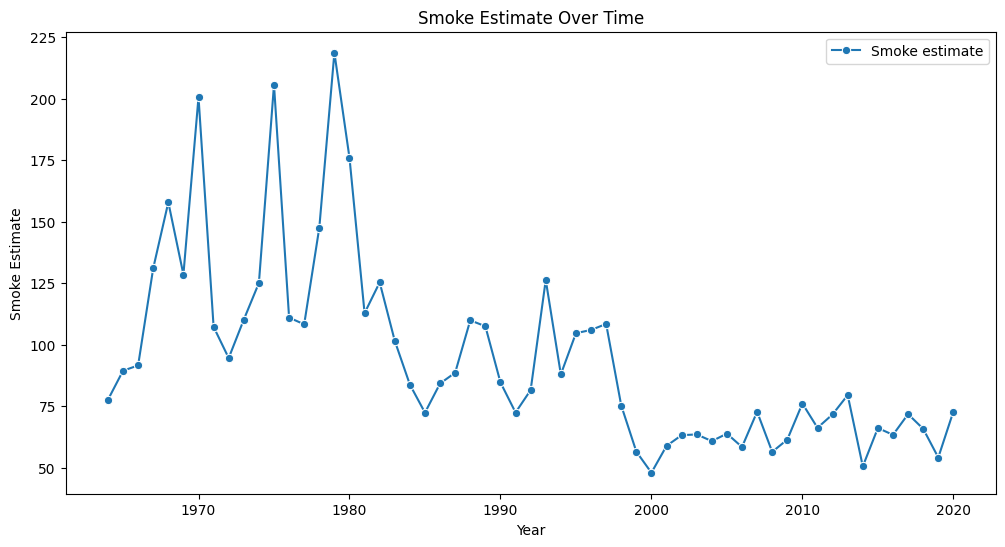

In [168]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=smoke_estimate_per_year, x='year', y='smoke_estimate', marker='o', label='Smoke estimate')

plt.title('Smoke Estimate Over Time')
# add labels
plt.xlabel('Year')
plt.ylabel('Smoke Estimate')
plt.legend()
plt.show()


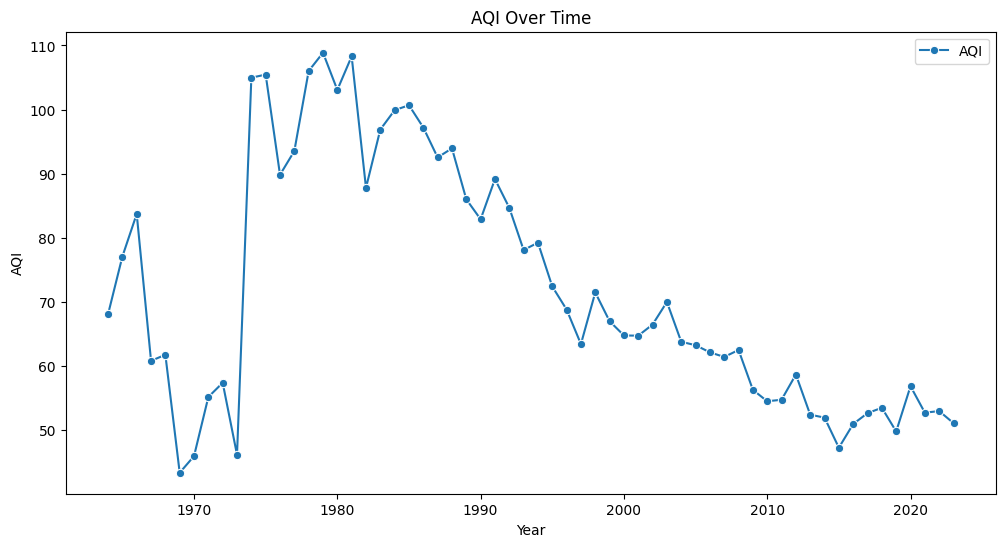

In [170]:
# now plot the aqi_df
plt.figure(figsize=(12, 6))
sns.lineplot(data=aqi_df_mean, x='year', y='aqi', marker='o', label='AQI')
plt.title('AQI Over Time')
# add labels
plt.xlabel('Year')
plt.ylabel('AQI')
plt.legend()
plt.show()

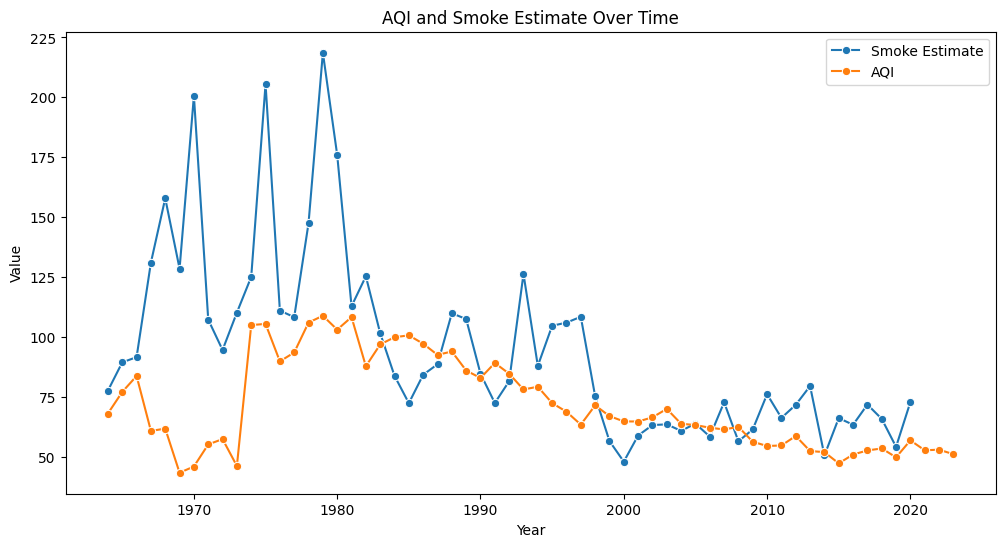

In [171]:
plt.figure(figsize=(12, 6))

sns.lineplot(data=smoke_estimate_per_year, x='year', y='smoke_estimate', marker='o', label='Smoke Estimate')
sns.lineplot(data=aqi_df_mean, x='year', y='aqi', marker='o', label='AQI')
# Add labels and title
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('AQI and Smoke Estimate Over Time')
plt.legend()
plt.show()